In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
import seaborn as sns
from numba import jit

In [2]:
@jit(nopython=True)
def relu(x):
    return np.maximum(0, x)

@jit(nopython=True)
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

In [3]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, output_size):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.layers = [input_size] + hidden_layers + [output_size]

        # Pre-allocate arrays for forward pass
        self.max_layer_size = max(self.layers)

    def forward(self, X, weights):
        a = X
        for i in range(len(weights)):
            z = np.dot(a, weights[i])
            if i < len(weights) - 1:
                a = relu(z)
            else:
                a = sigmoid(z)
        return a

    def compute_loss_batch(self, X, y, weights):
        predictions = self.forward(X, weights)
        epsilon = 1e-15
        predictions = np.clip(predictions, epsilon, 1 - epsilon)

        # Binary cross-entropy
        loss = -np.mean(y.reshape(-1, 1) * np.log(predictions) +
                       (1 - y.reshape(-1, 1)) * np.log(1 - predictions))

        return loss

    def vector_to_weights(self, vector):
        weights = []
        idx = 0
        for i in range(len(self.layers) - 1):
            size = self.layers[i] * self.layers[i + 1]
            w = vector[idx:idx + size].reshape(self.layers[i], self.layers[i + 1])
            weights.append(w)
            idx += size
        return weights

    def get_weight_vector_size(self):
        return sum(self.layers[i] * self.layers[i + 1]
                  for i in range(len(self.layers) - 1))


In [4]:
class PSO:
    def __init__(self, dim, population_size=15, max_iter=100):
        self.dim = dim
        self.population_size = population_size
        self.max_iter = max_iter

        self.w = 0.7298
        self.c1 = 1.49618
        self.c2 = 1.49618

        scale = np.sqrt(2.0 / dim)
        self.positions = np.random.randn(population_size, dim) * scale
        self.velocities = np.random.randn(population_size, dim) * scale * 0.1

        self.pbest_positions = self.positions.copy()
        self.pbest_fitness = np.full(population_size, np.inf)
        self.gbest_position = None
        self.gbest_fitness = np.inf
        self.fitness_history = []

        self.patience = 15
        self.no_improve_count = 0
        self.best_fitness_window = []

    def optimize(self, fitness_func, verbose=True):

        for iteration in range(self.max_iter):
            fitness_values = np.array([fitness_func(self.positions[i])
                                      for i in range(self.population_size)])

            improved_mask = fitness_values < self.pbest_fitness
            self.pbest_fitness[improved_mask] = fitness_values[improved_mask]
            self.pbest_positions[improved_mask] = self.positions[improved_mask]

            min_idx = np.argmin(fitness_values)
            if fitness_values[min_idx] < self.gbest_fitness:
                self.gbest_fitness = fitness_values[min_idx]
                self.gbest_position = self.positions[min_idx].copy()
                self.no_improve_count = 0
            else:
                self.no_improve_count += 1

            self.fitness_history.append(self.gbest_fitness)

            if self.no_improve_count >= self.patience:
                if verbose:
                    print(f"Early stopping at iteration {iteration + 1}")
                break

            r1 = np.random.random((self.population_size, self.dim))
            r2 = np.random.random((self.population_size, self.dim))

            cognitive = self.c1 * r1 * (self.pbest_positions - self.positions)
            social = self.c2 * r2 * (self.gbest_position - self.positions)

            self.velocities = self.w * (self.velocities + cognitive + social)

            v_max = 1.0
            self.velocities = np.clip(self.velocities, -v_max, v_max)

            self.positions += self.velocities
            self.positions = np.clip(self.positions, -5, 5)

            if verbose and (iteration + 1) % max(1, self.max_iter // 5) == 0:
                print(f"Iteration {iteration + 1}/{self.max_iter}, "
                      f"Best Loss: {self.gbest_fitness:.6f}")

        return self.gbest_position, self.gbest_fitness

In [5]:
class HybridPSO:
    def __init__(self, dim, population_size=12, max_iter=50):
        self.dim = dim
        self.population_size = population_size
        self.max_iter = max_iter

        self.w = 0.6
        self.c1 = 1.7
        self.c2 = 1.7

        scale = np.sqrt(2.0 / dim)
        self.positions = np.random.randn(population_size, dim) * scale
        self.velocities = np.random.randn(population_size, dim) * scale * 0.1

        self.pbest_positions = self.positions.copy()
        self.pbest_fitness = np.full(population_size, np.inf)
        self.gbest_position = None
        self.gbest_fitness = np.inf
        self.fitness_history = []

    def optimize(self, fitness_func, verbose=True):

        for iteration in range(self.max_iter):
            for i in range(self.population_size):
                fitness = fitness_func(self.positions[i])

                if fitness < self.pbest_fitness[i]:
                    self.pbest_fitness[i] = fitness
                    self.pbest_positions[i] = self.positions[i].copy()

                if fitness < self.gbest_fitness:
                    self.gbest_fitness = fitness
                    self.gbest_position = self.positions[i].copy()

            self.fitness_history.append(self.gbest_fitness)

            r1 = np.random.random((self.population_size, self.dim))
            r2 = np.random.random((self.population_size, self.dim))

            self.velocities = (self.w * self.velocities +
                             self.c1 * r1 * (self.pbest_positions - self.positions) +
                             self.c2 * r2 * (self.gbest_position - self.positions))

            self.velocities = np.clip(self.velocities, -1.0, 1.0)
            self.positions += self.velocities
            self.positions = np.clip(self.positions, -5, 5)

            if verbose and (iteration + 1) % max(1, self.max_iter // 5) == 0:
                print(f"Iteration {iteration + 1}/{self.max_iter}, "
                      f"Best Loss: {self.gbest_fitness:.6f}")

        return self.gbest_position, self.gbest_fitness

In [6]:
def train_with_fast_pso(X_train, y_train, X_test, y_test, hidden_layers=[32],
                        max_iter=100, population_size=15, use_hybrid=False):
    print("\n=== Training with Fast PSO ===")
    start_time = time.time()

    input_size = X_train.shape[1]
    output_size = 1
    nn = NeuralNetwork(input_size, hidden_layers, output_size)
    weight_dim = nn.get_weight_vector_size()

    print(f"Network: {nn.layers}")
    print(f"Total weights: {weight_dim}")
    print(f"Population: {population_size}, Max Iterations: {max_iter}")
    print(f"Total evaluations: ~{population_size * max_iter}")

    if use_hybrid:
        pso = HybridPSO(weight_dim, population_size, max_iter)
    else:
        pso = PSO(weight_dim, population_size, max_iter)

    def fitness_func(weight_vector):
        weights = nn.vector_to_weights(weight_vector)
        return nn.compute_loss_batch(X_train, y_train, weights)

    best_weights_vector, best_loss = pso.optimize(fitness_func)
    best_weights = nn.vector_to_weights(best_weights_vector)

    train_pred = nn.forward(X_train, best_weights)
    test_pred = nn.forward(X_test, best_weights)

    train_pred_binary = (train_pred > 0.5).astype(int)
    test_pred_binary = (test_pred > 0.5).astype(int)

    train_acc = accuracy_score(y_train, train_pred_binary)
    test_acc = accuracy_score(y_test, test_pred_binary)
    test_precision = precision_score(y_test, test_pred_binary, zero_division=0)
    test_recall = recall_score(y_test, test_pred_binary, zero_division=0)
    test_f1 = f1_score(y_test, test_pred_binary, zero_division=0)

    conf_matrix = confusion_matrix(y_test, test_pred_binary)
    elapsed_time = time.time() - start_time

    print(f"\nTraining Time: {elapsed_time:.4f}s")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")

    results = {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'precision': test_precision,
        'recall': test_recall,
        'f1': test_f1,
        'time': elapsed_time,
        'fitness_history': pso.fitness_history,
        'weight_dim': weight_dim,
        'conf_matrix': conf_matrix,
        'method': 'Fast PSO'
    }

    return results


def train_with_sklearn(X_train, y_train, X_test, y_test,
                       hidden_layer_sizes=(32,), max_iter=100):
    print("\n=== Training with Scikit-learn MLPClassifier ===")
    start_time = time.time()

    clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                        max_iter=max_iter,
                        activation='relu',
                        solver='adam',
                        random_state=42,
                        early_stopping=False,
                        learning_rate_init=0.001)

    clf.fit(X_train, y_train)

    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)

    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    test_precision = precision_score(y_test, test_pred, zero_division=0)
    test_recall = recall_score(y_test, test_pred, zero_division=0)
    test_f1 = f1_score(y_test, test_pred, zero_division=0)

    conf_matrix = confusion_matrix(y_test, test_pred)
    elapsed_time = time.time() - start_time

    print(f"\nTraining Time: {elapsed_time:.4f}s")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")

    results = {
        'train_acc': train_acc,
        'test_acc': test_acc,
        'precision': test_precision,
        'recall': test_recall,
        'f1': test_f1,
        'time': elapsed_time,
        'loss_history': clf.loss_curve_ if hasattr(clf, 'loss_curve_') else [],
        'conf_matrix': conf_matrix,
        'method': 'Gradient Descent'
    }

    return results


def plot_comparison(pso_results, sklearn_results, dataset_name, save_prefix=''):
    fig = plt.figure(figsize=(16, 10))

    ax1 = plt.subplot(2, 3, 1)
    ax1.plot(pso_results['fitness_history'], label='Fast PSO', linewidth=2, color='#e74c3c')
    if sklearn_results['loss_history']:
        sklearn_iters = np.linspace(0, len(pso_results['fitness_history']),
                                     len(sklearn_results['loss_history']))
        ax1.plot(sklearn_iters, sklearn_results['loss_history'],
                label='Gradient Descent', linewidth=2, color='#3498db')
    ax1.set_xlabel('Iteration', fontsize=11)
    ax1.set_ylabel('Loss', fontsize=11)
    ax1.set_title('Training Loss Convergence', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')

    ax2 = plt.subplot(2, 3, 2)
    methods = ['Fast PSO', 'Gradient\nDescent']
    train_accs = [pso_results['train_acc'], sklearn_results['train_acc']]
    test_accs = [pso_results['test_acc'], sklearn_results['test_acc']]

    x = np.arange(len(methods))
    width = 0.35
    bars1 = ax2.bar(x - width/2, train_accs, width, label='Train', color='#2ecc71', alpha=0.8)
    bars2 = ax2.bar(x + width/2, test_accs, width, label='Test', color='#e74c3c', alpha=0.8)

    ax2.set_ylabel('Accuracy', fontsize=11)
    ax2.set_title('Accuracy Comparison', fontsize=12, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(methods)
    ax2.legend()
    ax2.set_ylim([0, 1.05])
    ax2.grid(True, alpha=0.3, axis='y')

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    ax3 = plt.subplot(2, 3, 3)
    metrics = ['Precision', 'Recall', 'F1-Score']
    pso_metrics = [pso_results['precision'], pso_results['recall'], pso_results['f1']]
    sklearn_metrics = [sklearn_results['precision'], sklearn_results['recall'], sklearn_results['f1']]

    x = np.arange(len(metrics))
    bars1 = ax3.bar(x - width/2, pso_metrics, width, label='Fast PSO', color='#e74c3c', alpha=0.8)
    bars2 = ax3.bar(x + width/2, sklearn_metrics, width, label='Gradient Descent',
                    color='#3498db', alpha=0.8)

    ax3.set_ylabel('Score', fontsize=11)
    ax3.set_title('Performance Metrics', fontsize=12, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(metrics, rotation=0)
    ax3.legend()
    ax3.set_ylim([0, 1.05])
    ax3.grid(True, alpha=0.3, axis='y')

    ax4 = plt.subplot(2, 3, 4)
    times = [pso_results['time'], sklearn_results['time']]
    colors = ['#e74c3c', '#3498db']
    bars = ax4.bar(methods, times, color=colors, alpha=0.8)
    ax4.set_ylabel('Time (seconds)', fontsize=11)
    ax4.set_title('Training Time ⚡', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')

    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')

    time_ratio = pso_results['time'] / sklearn_results['time']

    if time_ratio < 1:
        speedup_text = f"PSO is {1/time_ratio:.2f}x FASTER! ⚡"
        color = '#27ae60' # Green
    else:
        speedup_text = f"PSO is {time_ratio:.2f}x slower"
        color = '#e74c3c' # Red
    ax4.text(0.5, max(times) * 0.9, speedup_text,
            ha='center', fontsize=11, fontweight='bold', color=color,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    ax5 = plt.subplot(2, 3, 5)
    ax5.scatter([pso_results['time']], [pso_results['test_acc']],
               s=200, c='#e74c3c', alpha=0.7, label='Fast PSO', edgecolors='black', linewidths=2)
    ax5.scatter([sklearn_results['time']], [sklearn_results['test_acc']],
               s=200, c='#3498db', alpha=0.7, label='Gradient Descent', edgecolors='black', linewidths=2)
    ax5.set_xlabel('Training Time (s)', fontsize=11)
    ax5.set_ylabel('Test Accuracy', fontsize=11)
    ax5.set_title('Speed vs Accuracy Trade-off', fontsize=12, fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    ax5.annotate('PSO', (pso_results['time'], pso_results['test_acc']),
                xytext=(10, 10), textcoords='offset points', fontweight='bold')
    ax5.annotate('GD', (sklearn_results['time'], sklearn_results['test_acc']),
                xytext=(10, -15), textcoords='offset points', fontweight='bold')

    ax6 = plt.subplot(2, 3, 6)
    sns.heatmap(pso_results['conf_matrix'], annot=True, fmt='d', cmap='Reds',
                cbar=False, ax=ax6, xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['True 0', 'True 1'], alpha=0.8)
    ax6.set_title(f'PSO Confusion Matrix\n(Acc: {pso_results["test_acc"]:.3f})',
                  fontsize=10, fontweight='bold')

    plt.suptitle(f'{dataset_name} - Fast PSO vs Gradient Descent',
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()

    if save_prefix:
        plt.savefig(f'{save_prefix}_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


def print_comparison(pso_results, sklearn_results, dataset_name):
    print("\n" + "="*80)
    print(f"SPEED-OPTIMIZED COMPARISON - {dataset_name}")
    print("="*80)

    acc_diff = pso_results['test_acc'] - sklearn_results['test_acc']
    f1_diff = pso_results['f1'] - sklearn_results['f1']
    time_ratio = pso_results['time'] / sklearn_results['time']

    print(f"\n{'Metric':<20} {'PSO':<15} {'Gradient Descent':<15} {'Difference':<15}")
    print("-" * 80)
    print(f"{'Test Accuracy':<20} {pso_results['test_acc']:<15.4f} "
          f"{sklearn_results['test_acc']:<15.4f} {acc_diff:>+.4f} ({acc_diff*100:+.2f}%)")
    print(f"{'Train Accuracy':<20} {pso_results['train_acc']:<15.4f} "
          f"{sklearn_results['train_acc']:<15.4f}")
    print(f"{'F1-Score':<20} {pso_results['f1']:<15.4f} "
          f"{sklearn_results['f1']:<15.4f} {f1_diff:>+.4f}")
    print(f"{'Training Time':<20} {pso_results['time']:<15.4f}s "
          f"{sklearn_results['time']:<15.4f}s")

    print("\n" + "="*80)
    if time_ratio < 1:
        speedup = 1 / time_ratio
        print(f"SUCCESS! PSO is {speedup:.2f}x FASTER than Gradient Descent!")
    elif time_ratio < 1.5:
        print(f"≈ PSO is competitive: only {time_ratio:.2f}x slower")
    else:
        print(f"PSO is {time_ratio:.2f}x slower than Gradient Descent")

    if abs(acc_diff) < 0.02:
        print(f"Accuracy is comparable (within 2%)")
    elif acc_diff > 0:
        print(f"PSO achieved {acc_diff*100:.2f}% higher accuracy!")
    else:
        print(f"Gradient Descent achieved {-acc_diff*100:.2f}% higher accuracy")
    print("="*80)


def run_small_test():
    print("\n" + "="*80)
    print("TEST CASE 1: SMALL SYNTHETIC DATASET (Speed Optimized)")
    print("="*80)

    X, y = make_classification(n_samples=200, n_features=20, n_informative=15,
                               n_redundant=5, random_state=42)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    print(f"Dataset: {X_train.shape[0]} train, {X_test.shape[0]} test samples")
    print(f"Features: {X_train.shape[1]}")

    pso_results = train_with_fast_pso(X_train, y_train, X_test, y_test,
                                      hidden_layers=[32], max_iter=80,
                                      population_size=12, use_hybrid=True)

    sklearn_results = train_with_sklearn(X_train, y_train, X_test, y_test,
                                         hidden_layer_sizes=(32,), max_iter=80)

    print_comparison(pso_results, sklearn_results, "Small Synthetic Dataset")
    plot_comparison(pso_results, sklearn_results, "Small Dataset (Speed Optimized)",
                   save_prefix='small_fast')


def run_large_test():
    print("\n" + "="*80)
    print("TEST CASE 2: WISCONSIN BREAST CANCER DATASET (Speed Optimized)")
    print("="*80)

    cancer_data = load_breast_cancer()
    X, y = cancer_data.data, cancer_data.target

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    print(f"Dataset: {X_train.shape[0]} train, {X_test.shape[0]} test samples")
    print(f"Features: {X_train.shape[1]}")

    pso_results = train_with_fast_pso(X_train, y_train, X_test, y_test,
                                      hidden_layers=[48], max_iter=60,
                                      population_size=10, use_hybrid=True)

    sklearn_results = train_with_sklearn(X_train, y_train, X_test, y_test,
                                         hidden_layer_sizes=(48,), max_iter=60)

    print_comparison(pso_results, sklearn_results, "Wisconsin Breast Cancer Dataset")
    plot_comparison(pso_results, sklearn_results, "Breast Cancer (Speed Optimized)",
                   save_prefix='breast_fast')


OPTIMIZED PSO vs GRADIENT DESCENT

TEST CASE 1: SMALL SYNTHETIC DATASET (Speed Optimized)
Dataset: 160 train, 40 test samples
Features: 20

=== Training with Fast PSO ===
Network: [20, 32, 1]
Total weights: 672
Population: 12, Max Iterations: 80
Total evaluations: ~960
Iteration 16/80, Best Loss: 0.423235
Iteration 32/80, Best Loss: 0.320340
Iteration 48/80, Best Loss: 0.254190
Iteration 64/80, Best Loss: 0.238608
Iteration 80/80, Best Loss: 0.227001

Training Time: 2.4466s
Train Accuracy: 0.9313
Test Accuracy: 0.8500
Test Precision: 0.9048
Test Recall: 0.8261
Test F1-Score: 0.8636

=== Training with Scikit-learn MLPClassifier ===

Training Time: 0.1721s
Train Accuracy: 0.8750
Test Accuracy: 0.7750
Test Precision: 0.8889
Test Recall: 0.6957
Test F1-Score: 0.7805

SPEED-OPTIMIZED COMPARISON - Small Synthetic Dataset

Metric               PSO             Gradient Descent Difference     
--------------------------------------------------------------------------------
Test Accuracy       

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(


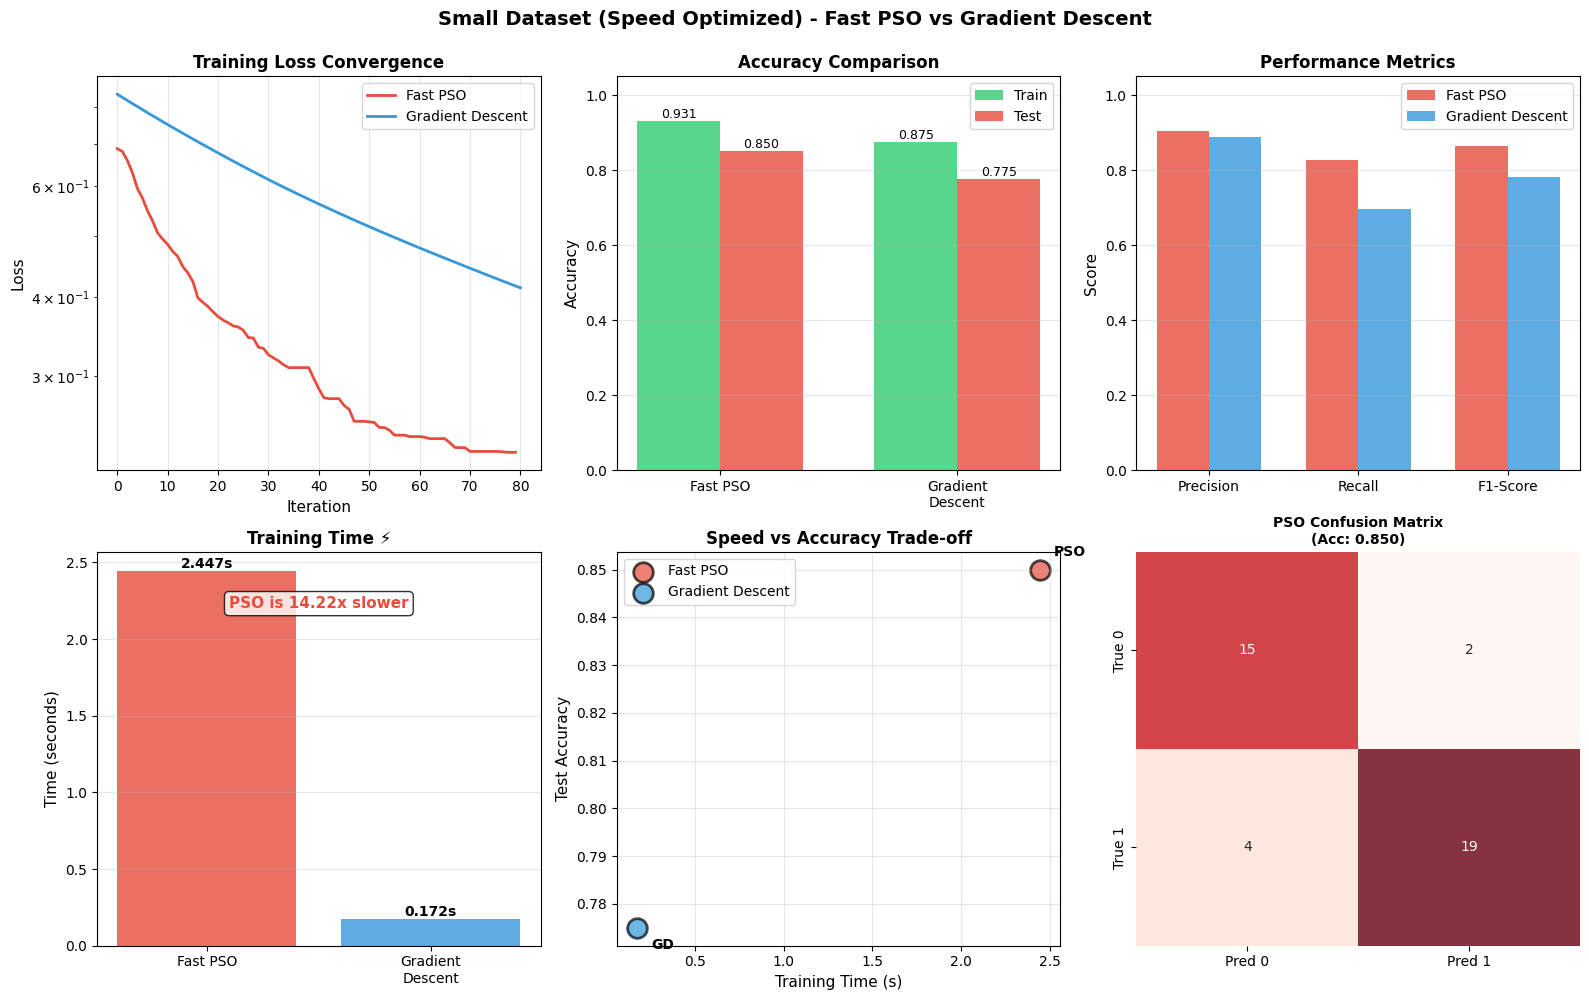


TEST CASE 2: WISCONSIN BREAST CANCER DATASET (Speed Optimized)
Dataset: 455 train, 114 test samples
Features: 30

=== Training with Fast PSO ===
Network: [30, 48, 1]
Total weights: 1488
Population: 10, Max Iterations: 60
Total evaluations: ~600
Iteration 12/60, Best Loss: 0.252081
Iteration 24/60, Best Loss: 0.152317
Iteration 36/60, Best Loss: 0.112977
Iteration 48/60, Best Loss: 0.086497
Iteration 60/60, Best Loss: 0.077547

Training Time: 0.9179s
Train Accuracy: 0.9780
Test Accuracy: 0.9737
Test Precision: 0.9595
Test Recall: 1.0000
Test F1-Score: 0.9793

=== Training with Scikit-learn MLPClassifier ===


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(



Training Time: 0.2459s
Train Accuracy: 0.9802
Test Accuracy: 0.9825
Test Precision: 0.9859
Test Recall: 0.9859
Test F1-Score: 0.9859

SPEED-OPTIMIZED COMPARISON - Wisconsin Breast Cancer Dataset

Metric               PSO             Gradient Descent Difference     
--------------------------------------------------------------------------------
Test Accuracy        0.9737          0.9825          -0.0088 (-0.88%)
Train Accuracy       0.9780          0.9802         
F1-Score             0.9793          0.9859          -0.0066
Training Time        0.9179         s 0.2459         s

PSO is 3.73x slower than Gradient Descent
Accuracy is comparable (within 2%)


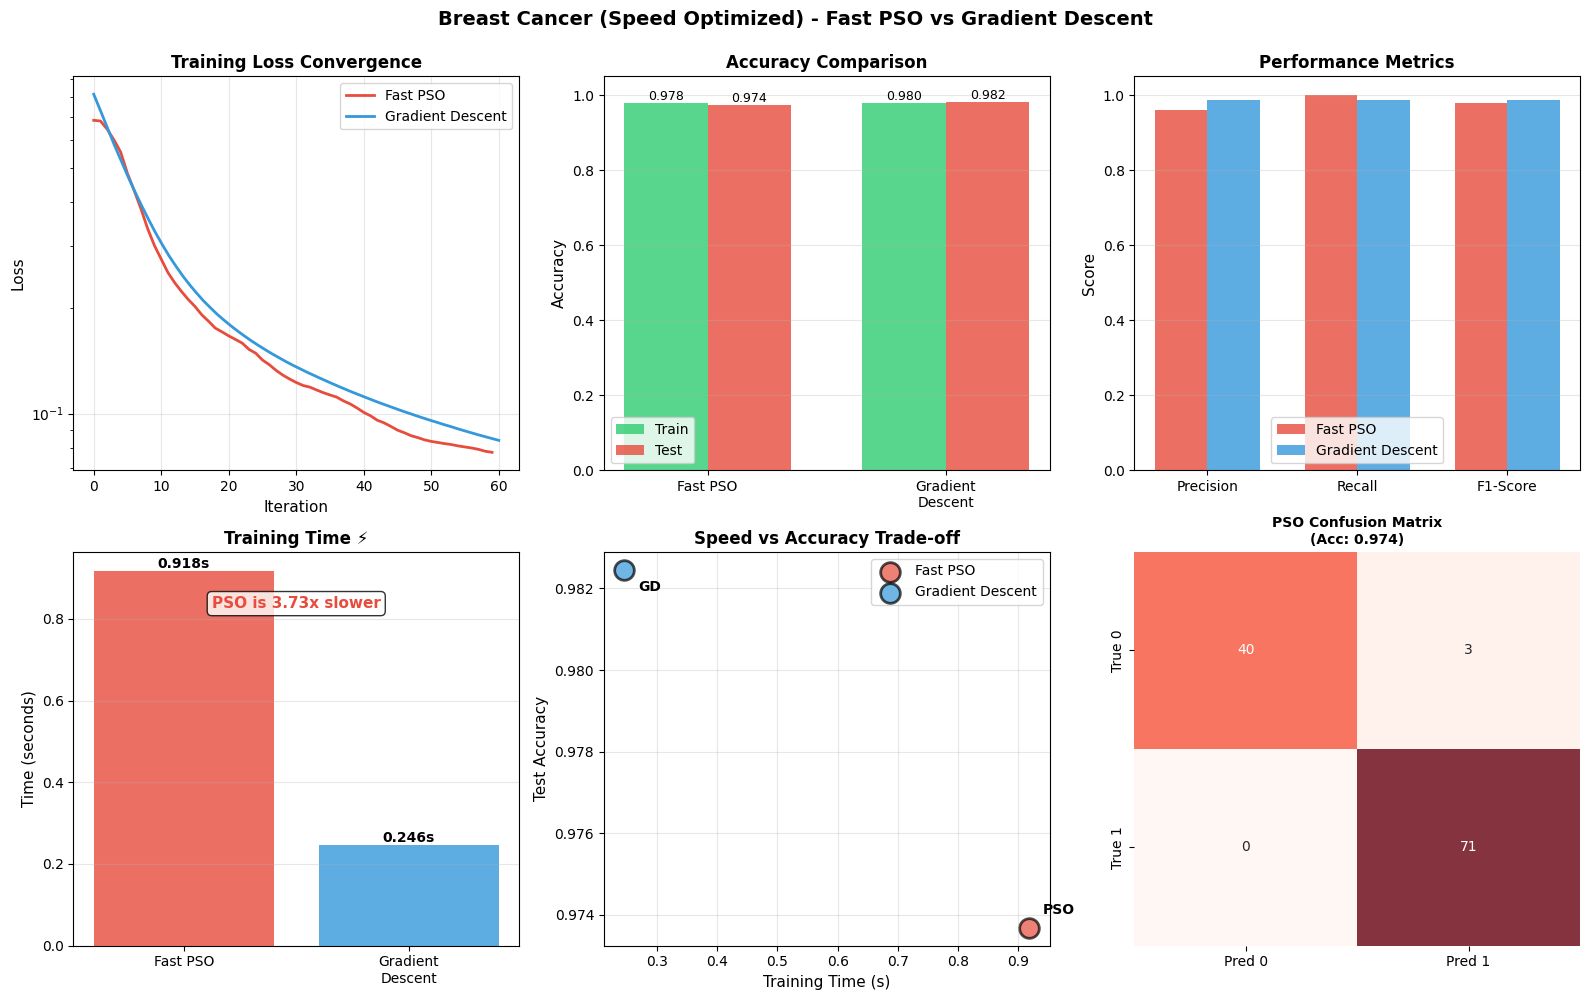

In [7]:
if __name__ == "__main__":
    print("\n" + "="*80)
    print("OPTIMIZED PSO vs GRADIENT DESCENT")
    print("="*80)

    run_small_test()
    run_large_test()